In [ ]:
# TODO RESTRUCTURE TO N,W,H,C

In [152]:
import numpy as np
from sklearn.preprocessing import MaxAbsScaler


class MinMaxScaler:
    """
    Used to scale and inverse scale features of data
    """

    def __init__(self, feature_range=(0, 1)):
        self.feature_range = feature_range

        self.min_new = None
        self.max_new = None
        self.scale_new = None

        self.min_old = None
        self.max_old = None
        self.scale_old = None

    def fit(self, data, axis):
        shape = np.shape(data)
        sum_axis = tuple(set(range(len(shape))) - {axis})

        self.min_old = np.min(data, axis=sum_axis, keepdims=True)
        self.max_old = np.max(data, axis=sum_axis, keepdims=True)
        self.scale_old = self.max_old - self.min_old
        
        self.min_new = np.ones_like(self.min_old) * self.feature_range[0]
        self.max_new = np.ones_like(self.max_old) * self.feature_range[1]
        self.scale_new = self.max_new - self.min_new
        

    def transform(self, data):
        return self.scale_new * (data - self.min_old) / self.scale_old + self.min_new

    def inverse_transform(self, data):
        return self.scale_old * (data - self.min_new) / self.scale_new + self.min_old

    def fit_transform(self, data, axis):
        self.fit(data, axis)
        return self.transform(data)


class MeanStdScaler:
    """
    Used to scale and inverse scale features of data
    """

    def __init__(self):
        self.mean_ = None
        self.max_old = None
        self.std_ = None

    def fit(self, data, axis):
        shape = np.shape(data)
        sum_axis = tuple(set(range(len(shape))) - {axis})

        self.mean_ = np.mean(data, axis=sum_axis, keepdims=True)
        self.std_ = np.std(data, axis=sum_axis, keepdims=True)

    def transform(self, data):
        return (data - self.mean_) / self.std_

    def inverse_transform(self, data):
        return self.std_ * data + self.mean_

    def fit_transform(self, data, axis):
        self.fit(data, axis)
        return self.transform(data)


### Note: use np.ravel_multi_index and np.unravel_index with get_item for datasets

In [153]:
# def __get_item__():
index = 34
t_size, x_size, y_size = 20, 5, 10
t,x,y = np.unravel_index(index, (t_size, x_size, y_size))
np.ravel_multi_index(multi_index=(t,x,y),dims=(t_size, x_size, y_size))

34

In [154]:
import numpy as np
from utils.plots import plot_dist
import matplotlib.pyplot as plt

In [164]:
minmax_scaler = MinMaxScaler(feature_range=(0,1))
meanstd_scaler = MeanStdScaler()

In [165]:
shape = n,c,h,w = 10, 3, 5, 3 
data = np.arange(np.product(shape)).reshape(shape)
data.shape
meanstd_data = meanstd_scaler.fit_transform(data,axis=1)
minmax_data = minmax_scaler.fit_transform(data,axis=1)


inv_meanstd_data = meanstd_scaler.inverse_transform(meanstd_data)
inv_minmax_data = minmax_scaler.inverse_transform(minmax_data)

In [166]:
np.sum(inv_minmax_data - inv_meanstd_data)

5.684341886080802e-14

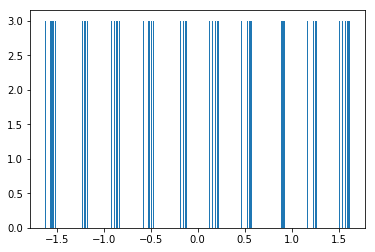

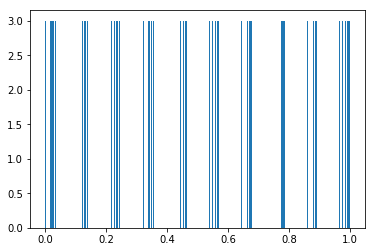

In [167]:
_=plt.hist(meanstd_data.flatten(),bins=1000)
plt.show()

_=plt.hist(minmax_data.flatten(),bins=1000)
plt.show()

In [170]:
minmax_data.mean(axis=(0,2,3),keepdims=True)

array([[[[0.5]],

        [[0.5]],

        [[0.5]]]])

## Todo have AUC per time frame
Use `auc = roc_auc_score(y_true, y_score)`


Base Line Models - models that might not be trainined in  batches but...non the less can be

In [4]:
from utils.data_processing import batchify, sequencify,encode_time_vectors

In [5]:
import pandas as pd

In [14]:
type(t_range.freq)

pandas.tseries.offsets.Hour

In [1]:
start_date = "2013-01-01"
end_date= "2013-02-01"
dT="24H"
    
t_range = pd.date_range(start_date, end_date, freq=dT)
encode_time_vectors(t_range)

NameError: name 'pd' is not defined

In [3]:
time_frame = t_range.freqstr

In [75]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.baseline_models import LinearRegressor
from dataloaders.generic_loader import GenericDataLoaders
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

In [76]:
data_dim_str = "T24H-X850M-Y880M"  # needs to exist
model_name = "MOCK-GRU-MODEL"  # needs to be created

data_path = f"./data/processed/{data_dim_str}/"
model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
conf_dict = {
                'shuffle': False,
                'use_cuda': False,
                'use_weighted_sampler': True,
                'early_stopping': False,
                'resume': True,
                'lr': 0.2,
                'weight_decay': 1e-4,
                'max_epochs': 30,
                'num_workers': 6,
                'seed': 3,
                'val_ratio': 0.1,
                'tst_ratio': 0.2,
                'batch_size': 200,
                'seq_len': 14,
    
}

conf = BaseConf(conf_dict)
log.info(f"\n\n=====================================CONF=====================================\n{conf}" + 
        "\n=====================================CONF=====================================\n")

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")

2019-08-15T12:25:18 | root | INFO | =====================================BEGIN=====================================
2019-08-15T12:25:18 | root | INFO | 

=====================================CONF=====================================
{'batch_size': 200,
 'early_stopping': False,
 'lr': 0.2,
 'max_epochs': 30,
 'num_workers': 6,
 'resume': True,
 'seed': 3,
 'seq_len': 14,
 'shuffle': False,
 'tst_ratio': 0.2,
 'use_cuda': False,
 'use_weighted_sampler': True,
 'val_ratio': 0.1,
 'weight_decay': 0.0001}
=====================================CONF=====================================

2019-08-15T12:25:18 | root | INFO | Device: cpu


In [77]:
zip_file = np.load(data_path + "generated_data.npz")

crime_types_grids = zip_file["crime_types_grids"]
street_grid = zip_file["street_grid"]
crime_grids = zip_file["crime_grids"]


In [80]:
np.shape(crime_grids)

print("crime_types_grids", np.shape(crime_types_grids))
print("street_grid",np.shape(street_grid))
print("crime_grids",np.shape(crime_grids))


crime_types_grids (1096, 10, 47, 33)
street_grid (512, 47, 33)
crime_grids (1096, 47, 33)


In [3]:
from datasets.generic_dataset import CrimeDataGroup

In [4]:
print(data_path + "generated_data.npz")
zip_file = np.load(data_path + "generated_data.npz")

crime_types_grids = zip_file["crime_types_grids"]
np.shape(crime_types_grids[:,0])


datagroup = CrimeDataGroup(data_path=data_path,conf=conf)

./data/processed/T24H-X850M-Y880M/generated_data.npz


AxisError: axis 1 is out of bounds for array of dimension 1

In [61]:
# have the train, validation and testing data available im memory
# (maybe not necessary to have test set in memory tpp)

N, d = 1000, 5
bias = -0.05
in_features = np.random.randn(N, d) + bias
targets = np.array(0.5 * (np.sign(np.sum(in_features, axis=1)) + 1), dtype=int)
log.info(f"Inverted Class Weights: {inv_weights(targets)}")

in_size = d
out_size = 2

# DATA LOADER SETUP
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
    pin_memory = True  # makes RAM -> GPU transfers quicker
else:
    torch.manual_seed(conf.seed)
    pin_memory = False

device = torch.device("cuda:0" if use_cuda else "cpu")

val_size = int(len(in_features) * conf.val_ratio)
tst_size = int(len(in_features) * conf.tst_ratio)

trn_index = (0, len(in_features) - tst_size - val_size)
val_index = (trn_index[1], len(in_features) - tst_size)
tst_index = (val_index[1], len(in_features))


training_weights = map_to_weights(targets[trn_index[0]:trn_index[1]])
validation_weights = map_to_weights(targets[val_index[0]:val_index[1]])
testing_weights = map_to_weights(targets[tst_index[0]:tst_index[1]])

"""
Important note on sampling
====
The entire dataset will still be seen by the model, but the distribution of labels
should tend to be uniformly distributed for the majority of the batches. If we want 
the batches to always remain uniformly distributed set -> replacement=True
"""
if conf.use_weighted_sampler:
    train_sampler = WeightedRandomSampler(weights=training_weights,
                                          num_samples=len(training_weights),
                                          replacement=False)
    validation_sampler = WeightedRandomSampler(weights=validation_weights,
                                               num_samples=len(validation_weights),
                                               replacement=False)
    testing_sampler = WeightedRandomSampler(weights=testing_weights,
                                            num_samples=len(testing_weights),
                                            replacement=False)
else:
    train_sampler = None
    validation_sampler = None
    testing_sampler = None

training_generator = DataLoader(dataset=training_set,
                                     batch_size=conf.batch_size,
                                     shuffle=conf.shuffle,
                                     num_workers=conf.num_workers,
                                     pin_memory=pin_memory,
                                     sampler=train_sampler)

validation_generator = DataLoader(dataset=validation_set,
                                       batch_size=conf.batch_size,
                                       shuffle=conf.shuffle,
                                       num_workers=conf.num_workers,
                                       pin_memory=pin_memory,
                                       sampler=validation_sampler)

testing_generator = DataLoader(dataset=testing_set,
                                    batch_size=conf.batch_size,
                                    shuffle=conf.shuffle,
                                    num_workers=conf.num_workers,
                                    pin_memory=pin_memory,
                                    sampler=testing_sampler)

2019-08-14T16:33:56 | root | INFO | Inverted Class Weights: [0.438 0.562]


tuple

2019-08-14T16:20:52 | root | INFO | Inverted Class Weights: [0.433 0.567]
2019-08-14T16:20:52 | root | INFO | Epoch 0 -> Training Loss: 		0.05021
2019-08-14T16:20:53 | root | INFO | Epoch 0 -> Validation Loss: 	0.04557
2019-08-14T16:20:53 | root | INFO | Epoch 0 -> Difference: 		-0.00464

2019-08-14T16:20:53 | root | INFO | Epoch 1 -> Training Loss: 		0.04733
2019-08-14T16:20:53 | root | INFO | Epoch 1 -> Validation Loss: 	0.04534
2019-08-14T16:20:53 | root | INFO | Epoch 1 -> Difference: 		-0.00199

2019-08-14T16:20:53 | root | INFO | Epoch 2 -> Training Loss: 		0.04947
2019-08-14T16:20:53 | root | INFO | Epoch 2 -> Validation Loss: 	0.04497
2019-08-14T16:20:53 | root | INFO | Epoch 2 -> Difference: 		-0.00450

2019-08-14T16:20:53 | root | INFO | Epoch 3 -> Training Loss: 		0.04754
2019-08-14T16:20:53 | root | INFO | Epoch 3 -> Validation Loss: 	0.04450
2019-08-14T16:20:53 | root | INFO | Epoch 3 -> Difference: 		-0.00304

2019-08-14T16:20:53 | root | INFO | Epoch 4 -> Training Loss: 

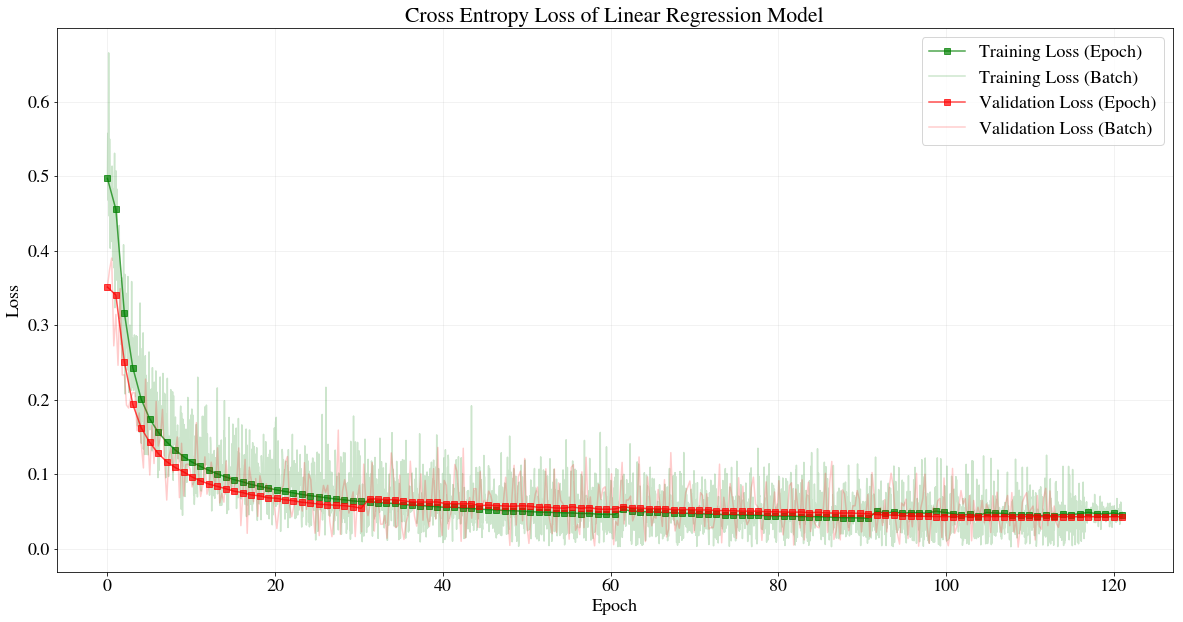

In [58]:
# GET DATA
loaders = GenericDataLoaders(conf=conf)  # torch seed is set in the data loaders

# TRAIN MODEL
model = LinearRegressor(in_features=loaders.in_size, out_features=loaders.out_size)
model.to(device)

loss_function = nn.CrossEntropyLoss()

trn_loss = []
val_loss = []
val_loss_best = float("inf")

all_trn_loss = []
all_val_loss = []

optimiser = optim.Adam(params=model.parameters(), lr=conf.lr, weight_decay=conf.weight_decay)
if conf.resume:
    # load model and optimiser states
    model.load_state_dict(torch.load(model_path + "model.pth"))
    optimiser.load_state_dict(torch.load(model_path + "optimiser.pth"))
    # load losses
    losses_zip = np.load(model_path + "losses.npz")
    all_val_loss = losses_zip["all_val_loss"].tolist()
    val_loss = losses_zip["val_loss"].tolist()
    trn_loss = losses_zip["trn_loss"].tolist()
    all_trn_loss = losses_zip["all_trn_loss"].tolist()
    val_loss_best = float(losses_zip["val_loss_best"])

for epoch in range(conf.max_epochs):
    timer.reset()
    # Training loop
    tmp_trn_loss = []
    for local_batch, local_labels in loaders.training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        out = model(local_batch.float())

        loss = loss_function(out, local_labels)
        tmp_trn_loss.append(loss.item())
        all_trn_loss.append(tmp_trn_loss[-1])

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    trn_loss.append(np.mean(tmp_trn_loss))
    log.debug(f"Epoch {epoch} -> Training Loop Duration: {timer.check()}")
    timer.reset()

    # Validation loop
    tmp_val_loss = []
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        for local_batch, local_labels in loaders.validation_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            out = model(local_batch.float())

            loss = loss_function(out, local_labels)
            tmp_val_loss.append(loss.item())
            all_val_loss.append(tmp_val_loss[-1])
    val_loss.append(np.mean(tmp_val_loss))
    log.debug(f"Epoch {epoch} -> Validation Loop Duration: {timer.check()}")

    log.info(f"Epoch {epoch} -> Training Loss: \t\t{trn_loss[-1]:.5f}")
    log.info(f"Epoch {epoch} -> Validation Loss: \t{val_loss[-1]:.5f}")
    log.info(f"Epoch {epoch} -> Difference: \t\t{(val_loss[-1]-trn_loss[-1]):.5f}\n")


    # save best model
    if min(val_loss) < val_loss_best:
        val_loss_best = min(val_loss)
        torch.save(model.state_dict(), model_path + "model_best.pth")
        torch.save(optimiser.state_dict(), model_path + "optimiser_best.pth")

    # model has been over-fitting stop maybe? # average of val_loss has increase - starting to over-fit
    if conf.early_stopping and epoch != 0 and val_loss[-1] > val_loss[-2]:
        log.warning("Over-fitting has taken place - stopping early")
        break

    # checkpoint - save models and loss values
    torch.save(model.state_dict(), model_path + "model.pth")
    torch.save(optimiser.state_dict(), model_path + "optimiser.pth")
    np.savez_compressed(model_path + "losses.npz",
                        all_val_loss=all_val_loss,
                        val_loss=val_loss,
                        trn_loss=trn_loss,
                        all_trn_loss=all_trn_loss,
                        val_loss_best=val_loss_best)

# Save training and validation plots
loss_plotter = LossPlotter(title="Cross Entropy Loss of Linear Regression Model")
loss_plotter.plot_losses(trn_loss, all_trn_loss, val_loss, all_val_loss)
loss_plotter.show()
#     loss_plotter.savefig(model_path + "plot_train_val_loss.png")

2019-08-14T16:20:58 | root | INFO | Accuracy:		 0.9900
2019-08-14T16:20:58 | root | INFO | ROC AUC:		 0.9996
2019-08-14T16:20:58 | root | INFO | Average Precision:	 0.9995


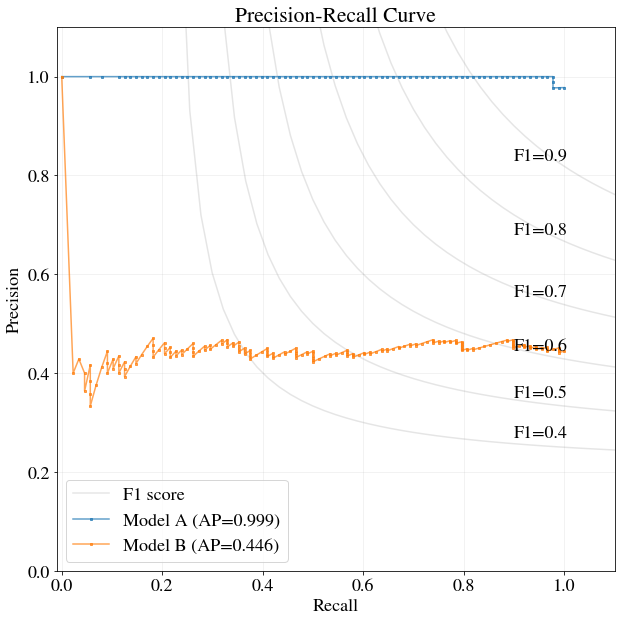

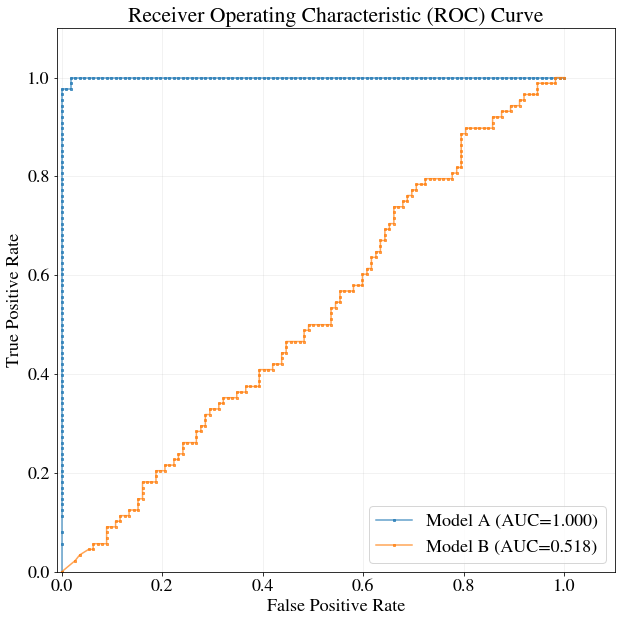

2019-08-14T16:20:58 | root | INFO | =====================================END=====================================


In [59]:

# EVALUATE MODEL
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    for local_batch, local_labels in loaders.testing_generator:  # loop through is set does not fit in batch
        y_true.extend(local_labels.tolist())
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        out = model(local_batch.float())
        out = F.softmax(out, dim=1)
        out_label = torch.argmax(out, dim=1)
        y_pred.extend(out_label.tolist())
        out_proba = out[:, 1]  # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())

acc = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, probas_pred)
ap = average_precision_score(y_true, probas_pred)
log.info(f"Accuracy:\t\t {acc:.4f}")
log.info(f"ROC AUC:\t\t {auc:.4f}")
log.info(f"Average Precision:\t {ap:.4f}")

np.savez_compressed(model_path + "evaluation_results.npz",
                    acc=acc,
                    auc=auc,
                    ap=ap,
                    y_true=y_true,
                    y_pred=y_pred,
                    probas_pred=probas_pred)

pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="Model A")
pr_plotter.add_curve(y_true, np.roll(probas_pred, 1), label_name="Model B")
pr_plotter.show()
#     pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="Model A")
roc_plotter.add_curve(y_true, np.roll(probas_pred, 1), label_name="Model B")
roc_plotter.show()
#     roc_plotter.savefig(model_path + "plot_roc_curve.png")

info["stop_time"] = strftime("%Y-%m-%dT%H:%M:%S")
write_json(info, model_path + "info.json")

log.info("=====================================END=====================================")
